In [1]:
%matplotlib inline

import os
import json
import matplotlib
import numpy as np
import scipy.stats
import pandas as pd
from collections import Counter

In [8]:
epsList = ['0', '0.5', '1', '1.5', '2', '3', '4']
# TODO: CHANGE THIS AS WE ANALYZE MORE SAMPLES
numSamples = 100
correctList = ['Valid Eps 0 Classification']
dfDict = {}

df = pd.DataFrame(index=[str(i) for i in range(numSamples)])
for eps in epsList:
    pcaPath = "results/sample%d/pca_eps_%s_600_amortized.json" % (numSamples, eps)
    noPCAPath = "results/sample%d/no_pca_eps_%s_600_amortized.json" % (numSamples, eps)
    dfPCA = pd.read_json(path_or_buf=pcaPath, orient='columns')
    dfNoPCA = pd.read_json(path_or_buf=noPCAPath, orient='columns')
    dfPCA = dfPCA.join(other=dfNoPCA, how='right', lsuffix=' PCA', rsuffix=' NO PCA')
    
    # Add a column to indicate which samples were classified correctly
    prefix = 'Eps %s' % eps
    pcaColList = ['Adv%d %s Classification PCA' % (i, prefix) for i in range(9)]
    noPCAColList = ['Adv%d %s Classification NO PCA' % (i, prefix) for i in range(9)]
    dfPCA['%s Correct Classification PCA' % prefix] = 45 - dfPCA[pcaColList].sum(axis=1)
    dfPCA['%s Correct Classification NO PCA' % prefix] = 45 - dfPCA[noPCAColList].sum(axis=1)
    
    dfPCA['%s Correct PCA' % prefix] = (dfPCA['%s Correct Classification PCA' % prefix] == dfPCA['Valid %s Classification PCA' % prefix])
    dfPCA['%s Correct NO PCA' % prefix] = (dfPCA['%s Correct Classification NO PCA' % prefix] == dfPCA['Valid %s Classification NO PCA' % prefix])
    
    dfDict[eps] = dfPCA

In [10]:
# Only care about rows where both models classified correctly.
for eps in dfDict:
    prefix = 'Eps %s' % eps
    pcaCorrect = '%s Correct PCA' % prefix
    noPCACorrect = '%s Correct NO PCA' % prefix
    df = dfDict[eps]
    dfDict[eps] = df[df[pcaCorrect] & df[noPCACorrect]]

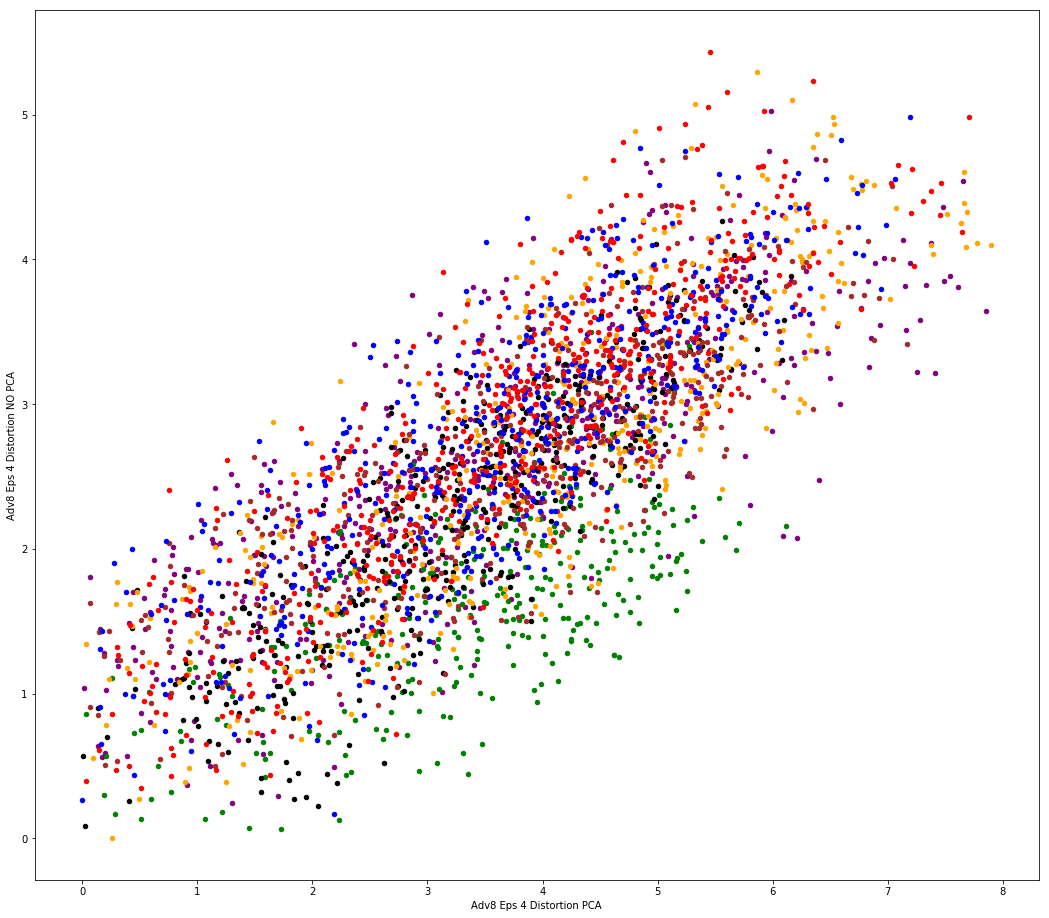

In [14]:
# TODO: Save plots separately, maybe plot regression lines as well?
ax = None
colorMap = {'0': 'purple', '0.5': 'green', '1': 'black', '1.5': 'orange', '2': 'brown', '3': 'blue', '4': 'red'}

for eps in dfDict:  
    for i in range(9):
        pcaLabel = "Adv%d Eps %s Distortion PCA" % (i, eps)
        noPCALabel = "Adv%d Eps %s Distortion NO PCA" % (i, eps)
        
        if ax is None:
            ax = dfDict[eps].plot(kind='scatter', x=pcaLabel, y=noPCALabel, c=colorMap[eps], figsize=(18, 16))
        else:
            dfDict[eps].plot(kind='scatter', x=pcaLabel, y=noPCALabel, c=colorMap[eps], ax=ax, figsize=(18, 16))

In [15]:
# TODO: Plot the regression lines
slopeDict = {}
interceptDict = {}
for eps in dfDict:
    x = []
    y = []
    for i in range(9):
        xLabel = "Adv%d Eps %s Distortion PCA" % (i, eps)
        yLabel = "Adv%d Eps %s Distortion NO PCA" % (i, eps)
        
        x.extend(dfDict[eps][xLabel].values)
        y.extend(dfDict[eps][yLabel].values)
        
    reg = scipy.stats.linregress(x, y)
    slopeDict[eps] = reg[0]
    interceptDict[eps] = reg[1]
print(slopeDict)
print(interceptDict)

{'0': 0.41859668572724285, '0.5': 0.34271581931898626, '1': 0.5699876790204667, '1.5': 0.5067425094753081, '2': 0.4443118866628856, '3': 0.5071159135641056, '4': 0.581849705546705}
{'0': 1.1064745737121033, '0.5': 0.47732004190284916, '1': 0.4024710545211503, '1.5': 0.7240994844469486, '2': 0.945795774720736, '3': 0.908800290876312, '4': 0.6812111921993664}


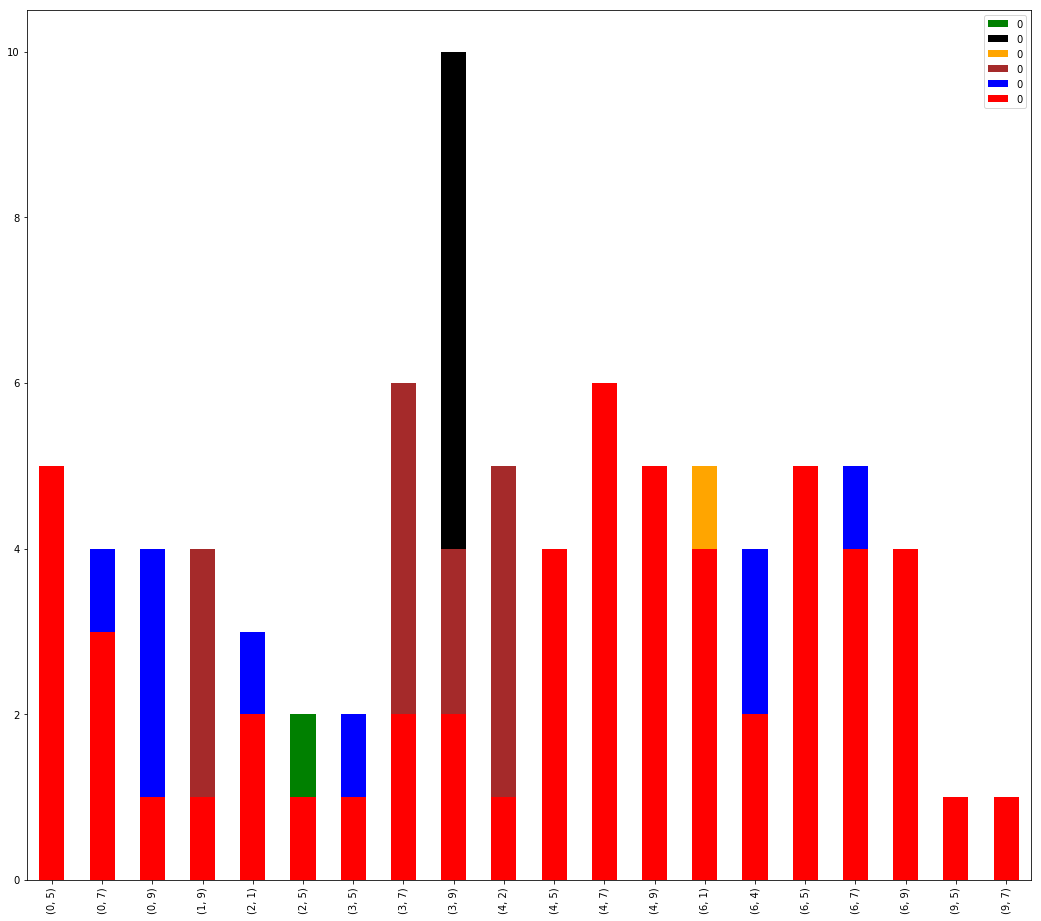

In [9]:
# When is DP much better than no DP?
dpBetterCorrect = {}
dpBetterAdv = {}
dpBetterDict = {}
dpBetterPairs = {}
dpHist = None

for eps in dfDict:
    if eps in ['0.1', '0.2']:
        continue
    
    dpBetterCorrect[eps] = []
    dpBetterAdv[eps] = []
    
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        dpBetterDict[eps] = dfDict[eps][dfDict[eps][epsLabel] >= dfDict[eps][zeroLabel] * 1.5]
        
        dpBetterCorrect[eps].extend(dpBetterDict[eps]["Valid Eps %s Classification" % eps].values)
        dpBetterAdv[eps].extend(dpBetterDict[eps]["Adv%d Eps %s Classification" % (i, eps)].values)

for eps in dpBetterCorrect:
    dpBetterPairs[eps] = [(dpBetterCorrect[eps][i], dpBetterAdv[eps][i]) for i in range(len(dpBetterCorrect[eps]))]
    dpBetterPairs[eps].sort()
    
    dpBetterPairsDF = pd.DataFrame.from_dict(Counter(dpBetterPairs[eps]), orient='index')
    if dpBetterPairsDF.empty:
        continue
    
    if (dpHist is None):
        dpHist = dpBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16))
    else:
        dpBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16), ax=dpHist)
dpHist

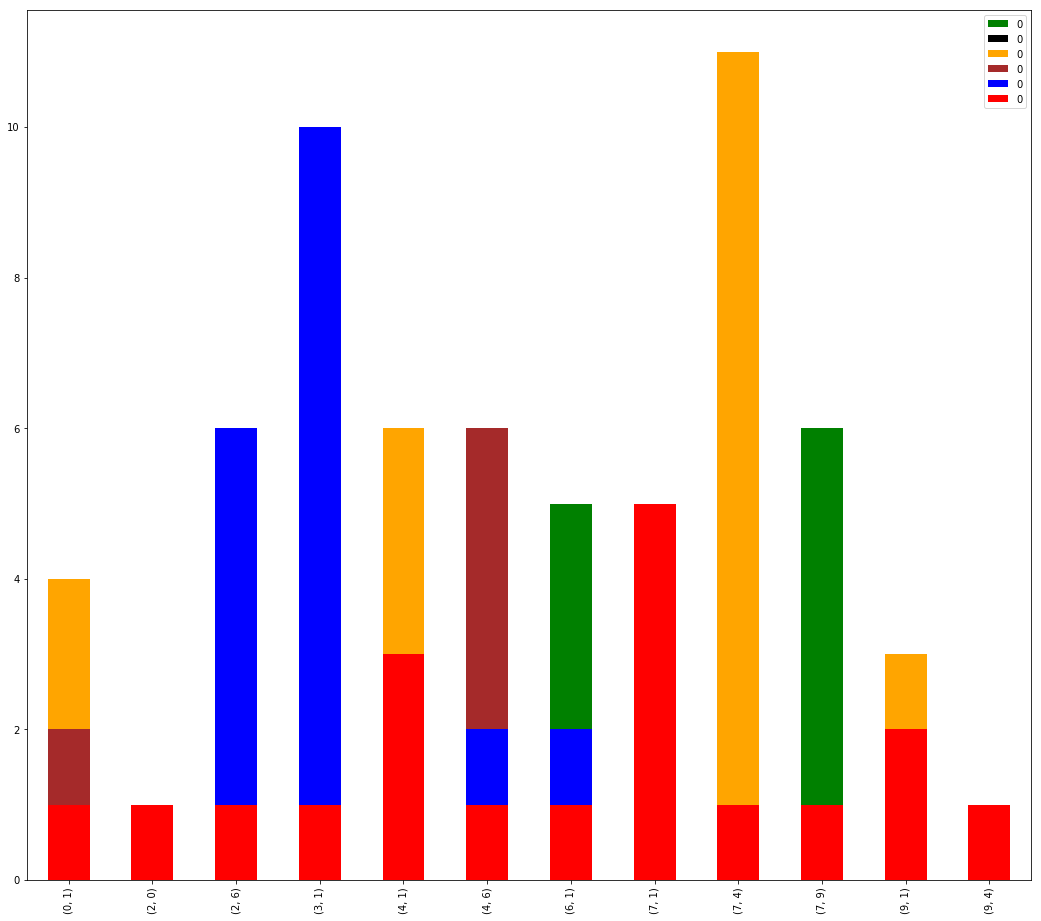

In [10]:
# When is no DP much better than DP?
noDPBetterCorrect = {}
noDPBetterAdv = {}
noDPBetterDict = {}
noDPBetterPairs = {}
noDPHist = None

for eps in dfDict:
    if eps in ['0.1', '0.2']:
        continue
    
    noDPBetterCorrect[eps] = []
    noDPBetterAdv[eps] = []
    
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        noDPBetterDict[eps] = dfDict[eps][dfDict[eps][zeroLabel] >= dfDict[eps][epsLabel] * 1.5]
        
        noDPBetterCorrect[eps].extend(noDPBetterDict[eps]["Valid Eps %s Classification" % eps].values)
        noDPBetterAdv[eps].extend(noDPBetterDict[eps]["Adv%d Eps %s Classification" % (i, eps)].values)

for eps in noDPBetterCorrect:
    noDPBetterPairs[eps] = [(noDPBetterCorrect[eps][i], noDPBetterAdv[eps][i]) for i in range(len(noDPBetterCorrect[eps]))]
    noDPBetterPairs[eps].sort()
    
    noDPBetterPairsDF = pd.DataFrame.from_dict(Counter(noDPBetterPairs[eps]), orient='index')
    if noDPBetterPairsDF.empty:
        continue
    
    if (noDPHist is None):
        noDPHist = noDPBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16))
    else:
        noDPBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16), ax=noDPHist)
noDPHist